In [1]:
# import the code from ./lib.factorization
# first uncompress it from ./lib.zip
#!unzip -o lib.zip
import sys, os
sys.path.append('../../')
from lib.factorization import *
from lib.utils.layer_fusion import fuse_batch_norm_inference, fuse_conv_bn, get_conv_bn_fuse_pairs
# ============================================
# Setup
# ============================================
import torch, time, pandas as pd, numpy as np, matplotlib.pyplot as plt
import torchvision
from torchvision.models import resnet50, ResNet50_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #  torch.device("cpu")
print("Using device:", device)

channels_last = False
use_amp = False

dtype = torch.float16 if use_amp and device.type == "cuda" else torch.float32
memory_format = torch.channels_last if channels_last else torch.contiguous_format

# ============================================
# Config
# ============================================
BATCH_SIZES = (8, 16, 32)
OUTPUT_PDF = "../../results/imagenet/plots/speedup_resnet50.pdf"

os.makedirs(os.path.dirname(OUTPUT_PDF), exist_ok=True)

# ============================================
# Baseline model (torchvision ResNet-50)
# ============================================
print("Loading Model A (torchvision ResNet-50 pretrained)...")
model_a = resnet50(weights=ResNet50_Weights.DEFAULT).to(device).eval()
# (Optional: collect conv-bn fuse pairs; kept here to mirror ViT script structure)
keys = get_conv_bn_fuse_pairs(model_a)

# dont fuse
#fuse_conv_bn = lambda model, keys, fuse_impl, inplace: model
model_a = fuse_conv_bn(
    model_a, keys, fuse_impl=fuse_batch_norm_inference, inplace=True
)

if channels_last:
    try: model_a = model_a.to(memory_format=torch.channels_last)
    except Exception: pass
print("Model A ready (ResNet-50 torchvision).")

# ============================================
# Benchmark helper
# ============================================
def _sync():
    if torch.cuda.is_available():
        torch.cuda.synchronize()

# benchmark
torch.backends.cudnn.benchmark = True
def run_benchmark(model, batch_sizes=BATCH_SIZES, iters=10, warmup=3):
    """
    Runs per-iteration timing so we can report mean and std across iterations.
    Returns a DataFrame with mean/std for batch time and images/sec.
    """
    rows = []
    for bs in batch_sizes:
        x = torch.randn(bs, 3, 224, 224, device=device, dtype=dtype)
        if memory_format == torch.channels_last:
            x = x.to(memory_format=torch.channels_last)

        # Warmup
        for _ in range(warmup):
            if use_amp and device.type == "cuda":
                with torch.autocast(device_type="cuda", dtype=torch.float16):
                    _ = model(x)
            else:
                _ = model(x)
            _sync()

        # Timed iterations — collect per-iter times (ms)
        times_ms = []
        for _ in range(iters):
            t0 = time.perf_counter()
            if use_amp and device.type == "cuda":
                with torch.autocast(device_type="cuda", dtype=torch.float16):
                    _ = model(x)
            else:
                _ = model(x)
            _sync()
            dt_ms = (time.perf_counter() - t0) * 1000.0
            times_ms.append(dt_ms)

        times_ms = np.array(times_ms, dtype=np.float64)
        mean_ms = float(times_ms.mean())
        std_ms = float(times_ms.std(ddof=1)) if len(times_ms) > 1 else 0.0

        # Convert to images/sec per-iteration, then summarize
        ips_per_iter = bs / (times_ms / 1000.0)
        mean_ips = float(ips_per_iter.mean())
        std_ips  = float(ips_per_iter.std(ddof=1)) if len(ips_per_iter) > 1 else 0.0

        rows.append({
            "batch_size": bs,
            "mean_batch_time_ms": mean_ms,
            "std_batch_time_ms": std_ms,
            "mean_images_per_sec": mean_ips,
            "std_images_per_sec": std_ips,
            "iterations": iters,
            "warmup": warmup,
        })
    return pd.DataFrame(rows)

# baseline benchmark
print("Benchmarking baseline (torchvision ResNet-50)...")
res_baseline = run_benchmark(model_a)
res_baseline = res_baseline.rename(columns={
    "mean_batch_time_ms": "mean_batch_time_ms_resnet50_torchvision",
    "std_batch_time_ms": "std_batch_time_ms_resnet50_torchvision",
    "mean_images_per_sec": "mean_images_per_sec_resnet50_torchvision",
    "std_images_per_sec": "std_images_per_sec_resnet50_torchvision",
})

del model_a
torch.cuda.empty_cache()
# ============================================
# Model B variants
# ============================================
ratios = [0.3, 0.5, 0.6, 0.7, 0.85]
base_path = "../../results/imagenet/resnet50/factorized_posttrain/flops_auto/flops_auto"

def load_model_b(ratio: float):
    path = os.path.join(base_path, f"model_resnet50_ratio_{ratio:.6f}.pth")
    print(f"\nLoading Model B (ratio={ratio}) from: {path}")
    if not os.path.exists(path):
        print("  -> SKIP: file not found")
        return None
    mb = torch.load(path, map_location=device, weights_only=False)
    if hasattr(mb, "to"):
        mb = mb.to(device).eval()
        if channels_last:
            try: mb = mb.to(memory_format=torch.channels_last)
            except Exception: pass
    print("Model B ready.")
    mb = fuse_conv_bn(
        mb, keys, fuse_impl=fuse_batch_norm_inference, inplace=True
    )
    return mb

def propagate_speedup_std(mean_a, std_a, mean_b, std_b):
    """
    Delta-method error propagation for ratio s = mean_b / mean_a.
    Assumes independence between A and B timings.
    """
    if mean_a == 0 or mean_b == 0:
        return 0.0
    s = mean_b / mean_a
    rel_var = (std_b / mean_b) ** 2 + (std_a / mean_a) ** 2
    return s * (rel_var ** 0.5)

detailed_rows = []

for r in ratios:
    model_b = load_model_b(r)
    if model_b is None:
        continue

    print(f"Benchmarking Model B @ ratio={r} ...")
    res_b = run_benchmark(model_b)
    res_b = res_b.rename(columns={
        "mean_batch_time_ms": "mean_batch_time_ms_resnet50_loaded",
        "std_batch_time_ms": "std_batch_time_ms_resnet50_loaded",
        "mean_images_per_sec": "mean_images_per_sec_resnet50_loaded",
        "std_images_per_sec": "std_images_per_sec_resnet50_loaded",
    })

    df = res_baseline.merge(res_b, on=["batch_size","iterations","warmup"], how="inner")

    # Speedup as ratio of mean IPS; std via error propagation
    df["speedup_vs_torchvision_resnet50_mean"] = (
        df["mean_images_per_sec_resnet50_loaded"] / df["mean_images_per_sec_resnet50_torchvision"]
    )
    df["speedup_vs_torchvision_resnet50_std"] = [
        propagate_speedup_std(a_mean, a_std, b_mean, b_std)
        for a_mean, a_std, b_mean, b_std in zip(
            df["mean_images_per_sec_resnet50_torchvision"],
            df["std_images_per_sec_resnet50_torchvision"],
            df["mean_images_per_sec_resnet50_loaded"],
            df["std_images_per_sec_resnet50_loaded"],
        )
    ]
    df["ratio"] = r
    detailed_rows.append(df)

    # delete model_b, free it!
    del model_b
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# ============================================
# Results summary (and optional plot placeholder)
# ============================================
if not detailed_rows:
    raise RuntimeError("No checkpoints found; nothing to plot.")

detailed_df = pd.concat(detailed_rows, ignore_index=True)

print("\n=== Detailed results (mean ± std) ===")
cols = [
    "ratio","batch_size",
    "mean_images_per_sec_resnet50_torchvision","std_images_per_sec_resnet50_torchvision",
    "mean_images_per_sec_resnet50_loaded","std_images_per_sec_resnet50_loaded",
    "speedup_vs_torchvision_resnet50_mean","speedup_vs_torchvision_resnet50_std"
]
print(detailed_df[cols].sort_values(["batch_size","ratio"]).to_string(index=False))

# Optionally, save a CSV alongside the PDF figure path for reproducibility.
csv_out = os.path.splitext(OUTPUT_PDF)[0] + "_detailed_mean_std.csv"
os.makedirs(os.path.dirname(csv_out), exist_ok=True)
detailed_df.to_csv(csv_out, index=False)
print(f"\nSaved detailed CSV with mean/std to: {csv_out}")

# (Optional) You can add plotting here if desired and save to OUTPUT_PDF.
# For parity with your ViT script, we only prepare OUTPUT_PDF and skip plotting.



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\dagom\anaconda3\envs\torch\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\dagom\anaconda3\envs\torch\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\dagom\anaconda3\envs\torch\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Us

AttributeError: _ARRAY_API not found

Using device: cuda
Loading Model A (torchvision ResNet-50 pretrained)...
Model A ready (ResNet-50 torchvision).
Benchmarking baseline (torchvision ResNet-50)...

Loading Model B (ratio=0.3) from: ../../results/imagenet/resnet50/factorized_posttrain/flops_auto/flops_auto\model_resnet50_ratio_0.300000.pth
Model B ready.
Benchmarking Model B @ ratio=0.3 ...

Loading Model B (ratio=0.5) from: ../../results/imagenet/resnet50/factorized_posttrain/flops_auto/flops_auto\model_resnet50_ratio_0.500000.pth
Model B ready.
Benchmarking Model B @ ratio=0.5 ...

Loading Model B (ratio=0.6) from: ../../results/imagenet/resnet50/factorized_posttrain/flops_auto/flops_auto\model_resnet50_ratio_0.600000.pth
  -> SKIP: file not found

Loading Model B (ratio=0.7) from: ../../results/imagenet/resnet50/factorized_posttrain/flops_auto/flops_auto\model_resnet50_ratio_0.700000.pth
Model B ready.
Benchmarking Model B @ ratio=0.7 ...

Loading Model B (ratio=0.85) from: ../../results/imagenet/resnet50/factorized_po


Saved plot to: ../../results/imagenet/plots/speedup_resnet50.pdf


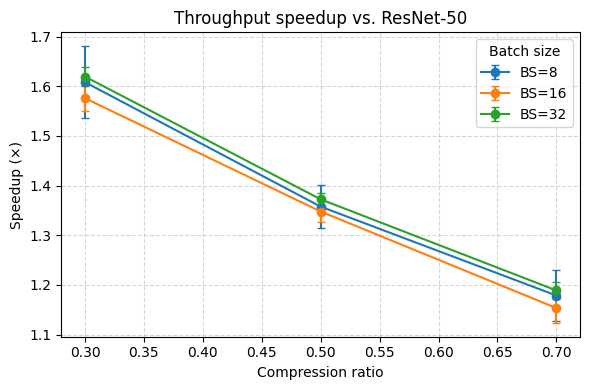

In [2]:
plt.figure(figsize=(6, 4))
for bs in BATCH_SIZES:
    sub = detailed_df[detailed_df["batch_size"] == bs].sort_values("ratio")
    plt.errorbar(
        sub["ratio"],
        sub["speedup_vs_torchvision_resnet50_mean"],
        yerr=sub["speedup_vs_torchvision_resnet50_std"],
        marker="o",
        capsize=3,
        label=f"BS={bs}"
    )

plt.title("Throughput speedup vs. ResNet-50")
plt.xlabel("Compression ratio")
plt.ylabel("Speedup (×)")
plt.legend(title="Batch size")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(OUTPUT_PDF, format="pdf", bbox_inches="tight")
print(f"\nSaved plot to: {OUTPUT_PDF}")
plt.show()  # enable if running interactively

In [1]:
# import the code from ./lib.factorization
# first uncompress it from ./lib.zip
#!unzip -o lib.zip
import sys, os
sys.path.append('../../')
from lib.factorization import *

# ============================================
# Setup
# ============================================
import torch, time, pandas as pd, numpy as np, timm, matplotlib.pyplot as plt

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

channels_last = False  
use_amp = False        

dtype = torch.float16 if use_amp and device.type == "cuda" else torch.float32
memory_format = torch.channels_last if channels_last else torch.contiguous_format

from lib.utils.layer_fusion import get_conv_bn_fuse_pairs

# ============================================
# Config
# ============================================
BATCH_SIZES = (8, 16, 32)  
OUTPUT_PDF = "../../results/imagenet/plots/speedup_vit.pdf"

os.makedirs(os.path.dirname(OUTPUT_PDF), exist_ok=True)

# ============================================
# Baseline model (timm ViT-B/16)
# ============================================
print("Loading Model A (timm ViT-B/16 pretrained)...")
model_a_vit = timm.create_model("vit_base_patch16_224", pretrained=True).to(device).eval()
_ = get_conv_bn_fuse_pairs(model_a_vit)

if channels_last:
    try: model_a_vit = model_a_vit.to(memory_format=torch.channels_last)
    except Exception: pass
print("Model A ready (ViT-B/16 timm).")

# ============================================
# Benchmark helper
# ============================================
def _sync():
    if torch.cuda.is_available():
        torch.cuda.synchronize()

def run_benchmark(model, batch_sizes=BATCH_SIZES, iters=10, warmup=2):
    """
    Runs per-iteration timing so we can report mean and std across iterations.
    Returns a DataFrame with mean/std for batch time and images/sec.
    """
    rows = []
    for bs in batch_sizes:
        x = torch.randn(bs, 3, 224, 224, device=device, dtype=dtype)
        if memory_format == torch.channels_last:
            x = x.to(memory_format=torch.channels_last)

        # Warmup
        for _ in range(warmup):
            if use_amp and device.type == "cuda":
                with torch.autocast(device_type="cuda", dtype=torch.float16):
                    _ = model(x)
            else: _ = model(x)
            _sync()

        # Timed iterations — collect per-iter times (ms)
        times_ms = []
        for _ in range(iters):
            t0 = time.perf_counter()
            if use_amp and device.type == "cuda":
                with torch.autocast(device_type="cuda", dtype=torch.float16):
                    _ = model(x)
            else:
                _ = model(x)
            _sync()
            dt_ms = (time.perf_counter() - t0) * 1000.0
            times_ms.append(dt_ms)

        times_ms = np.array(times_ms, dtype=np.float64)
        mean_ms = float(times_ms.mean())
        std_ms = float(times_ms.std(ddof=1)) if len(times_ms) > 1 else 0.0

        # Convert to images/sec per-iteration, then summarize
        ips_per_iter = bs / (times_ms / 1000.0)
        mean_ips = float(ips_per_iter.mean())
        std_ips  = float(ips_per_iter.std(ddof=1)) if len(ips_per_iter) > 1 else 0.0

        rows.append({
            "batch_size": bs,
            "mean_batch_time_ms": mean_ms,
            "std_batch_time_ms": std_ms,
            "mean_images_per_sec": mean_ips,
            "std_images_per_sec": std_ips,
            "iterations": iters,
            "warmup": warmup,
        })
    return pd.DataFrame(rows)

# baseline benchmark
print("Benchmarking baseline (timm ViT-B/16)...")
res_baseline = run_benchmark(model_a_vit)
res_baseline = res_baseline.rename(columns={
    "mean_batch_time_ms": "mean_batch_time_ms_vit_timm",
    "std_batch_time_ms": "std_batch_time_ms_vit_timm",
    "mean_images_per_sec": "mean_images_per_sec_vit_timm",
    "std_images_per_sec": "std_images_per_sec_vit_timm",
})

# ============================================
# Model B variants
# ============================================
ratios = [0.3, 0.5, 0.6, 0.7, 0.85]
base_path = "../../results/imagenet/vit_b_16/factorized_posttrain/flops_auto/flops_auto"

def load_model_b(ratio: float):
    path = os.path.join(base_path, f"model_vit_b_16_ratio_{ratio:.6f}.pth")
    print(f"\nLoading Model B (ratio={ratio}) from: {path}")
    if not os.path.exists(path):
        print("  -> SKIP: file not found")
        return None
    mb = torch.load(path, map_location=device, weights_only=False)
    if hasattr(mb, "to"):
        mb = mb.to(device).eval()
        if channels_last:
            try: mb = mb.to(memory_format=torch.channels_last)
            except Exception: pass
    print("Model B ready.")
    return mb

def propagate_speedup_std(mean_a, std_a, mean_b, std_b):
    """
    Delta-method error propagation for ratio s = mean_b / mean_a.
    Assumes independence between A and B timings.
    """
    if mean_a == 0 or mean_b == 0:
        return 0.0
    s = mean_b / mean_a
    rel_var = (std_b / mean_b) ** 2 + (std_a / mean_a) ** 2
    return s * (rel_var ** 0.5)

detailed_rows = []

for r in ratios:
    model_b = load_model_b(r)
    if model_b is None: continue

    print(f"Benchmarking Model B @ ratio={r} ...")
    res_b = run_benchmark(model_b)
    res_b = res_b.rename(columns={
        "mean_batch_time_ms": "mean_batch_time_ms_vit_loaded",
        "std_batch_time_ms": "std_batch_time_ms_vit_loaded",
        "mean_images_per_sec": "mean_images_per_sec_vit_loaded",
        "std_images_per_sec": "std_images_per_sec_vit_loaded",
    })

    df = res_baseline.merge(res_b, on=["batch_size","iterations","warmup"], how="inner")

    # Speedup as ratio of mean IPS; std via error propagation
    df["speedup_vs_timm_vit_mean"] = (
        df["mean_images_per_sec_vit_loaded"] / df["mean_images_per_sec_vit_timm"]
    )
    df["speedup_vs_timm_vit_std"] = [
        propagate_speedup_std(a_mean, a_std, b_mean, b_std)
        for a_mean, a_std, b_mean, b_std in zip(
            df["mean_images_per_sec_vit_timm"],
            df["std_images_per_sec_vit_timm"],
            df["mean_images_per_sec_vit_loaded"],
            df["std_images_per_sec_vit_loaded"],
        )
    ]
    df["ratio"] = r
    detailed_rows.append(df)

# ============================================
# Results summary + save
# ============================================
if not detailed_rows:
    raise RuntimeError("No checkpoints found; nothing to plot.")

detailed_df = pd.concat(detailed_rows, ignore_index=True)
print("\n=== Detailed results (mean ± std) ===")
print(detailed_df[[
    "ratio","batch_size",
    "mean_images_per_sec_vit_timm","std_images_per_sec_vit_timm",
    "mean_images_per_sec_vit_loaded","std_images_per_sec_vit_loaded",
    "speedup_vs_timm_vit_mean","speedup_vs_timm_vit_std"
]].sort_values(["batch_size","ratio"]).to_string(index=False))

# Save CSV
csv_out = os.path.splitext(OUTPUT_PDF)[0] + "_detailed_mean_std.csv"
os.makedirs(os.path.dirname(csv_out), exist_ok=True)
detailed_df.to_csv(csv_out, index=False)
print(f"\nSaved detailed CSV with mean/std to: {csv_out}")

# (Optional) plotting step can be added here to OUTPUT_PDF if needed.






A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\dagom\anaconda3\envs\torch\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\dagom\anaconda3\envs\torch\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\dagom\anaconda3\envs\torch\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Us

AttributeError: _ARRAY_API not found

c:\Users\dagom\anaconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Loading Model A (timm ViT-B/16 pretrained)...
Model A ready (ViT-B/16 timm).
Benchmarking baseline (timm ViT-B/16)...

Loading Model B (ratio=0.3) from: ../../results/imagenet/vit_b_16/factorized_posttrain/flops_auto/flops_auto\model_vit_b_16_ratio_0.300000.pth
Model B ready.
Benchmarking Model B @ ratio=0.3 ...

Loading Model B (ratio=0.5) from: ../../results/imagenet/vit_b_16/factorized_posttrain/flops_auto/flops_auto\model_vit_b_16_ratio_0.500000.pth
Model B ready.
Benchmarking Model B @ ratio=0.5 ...

Loading Model B (ratio=0.6) from: ../../results/imagenet/vit_b_16/factorized_posttrain/flops_auto/flops_auto\model_vit_b_16_ratio_0.600000.pth
Model B ready.
Benchmarking Model B @ ratio=0.6 ...

Loading Model B (ratio=0.7) from: ../../results/imagenet/vit_b_16/factorized_posttrain/flops_auto/flops_auto\model_vit_b_16_ratio_0.700000.pth
Model B ready.
Benchmarking Model B @ ratio=0.7 ...

Loading Model B (ratio=0.85) from: ../../results/imagenet/vit_b_16/factorized_


Saved plot to: ../../results/imagenet/plots/speedup_vit.pdf


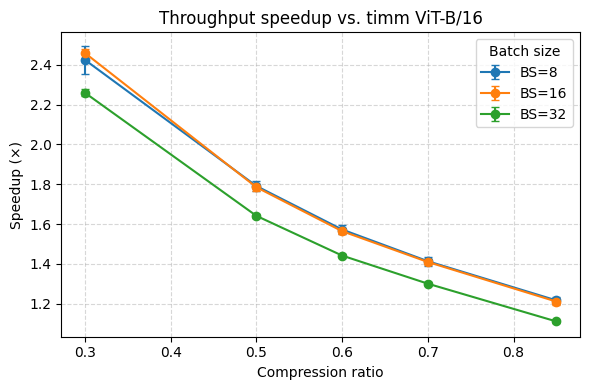

In [2]:
# ============================================
# Plot: one line per batch size with error bars
# ============================================
plt.figure(figsize=(6, 4))
for bs in BATCH_SIZES:
    sub = detailed_df[detailed_df["batch_size"] == bs].sort_values("ratio")
    plt.errorbar(
        sub["ratio"],
        sub["speedup_vs_timm_vit_mean"],
        yerr=sub["speedup_vs_timm_vit_std"],
        marker="o",
        capsize=3,
        label=f"BS={bs}"
    )

plt.title("Throughput speedup vs. timm ViT-B/16")
plt.xlabel("Compression ratio")
plt.ylabel("Speedup (×)")
plt.legend(title="Batch size")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(OUTPUT_PDF, format="pdf", bbox_inches="tight")
print(f"\nSaved plot to: {OUTPUT_PDF}")
plt.show()  # enable if running interactively